# API
descrição da API escolhida

### Pacotes e configs

In [1]:
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Configuração para não ocultar colunas ou linhas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# API
endpoint = "https://api-dados-abertos.cearatransparente.ce.gov.br/transparencia/contratos/contratos"
# Nao colocar a / no final
pasta_csv = "data"

ultimo_ano = 2024
primeiro_ano = 2024

### Acesso e download dos dados

In [3]:
%%time
# Coleta os dados partindo do mais rescente para o mais antigo
for ano in range(ultimo_ano, primeiro_ano - 1, -1):
    max_pages = 5
    last_page = 0

    all_contratos = []
    while last_page < max_pages:
        params = {
            "page": last_page + 1,
            "data_assinatura_inicio": f"01/01/{ano}",
            "data_assinatura_fim": f"31/12/{ano}",
        }

        res = requests.get(endpoint, params=params)


        if res.status_code == 200:
            data = res.json()

            total_pages = data["sumary"]["total_pages"]

            # Atualiza a ultima página consultada
            last_page = int(data["sumary"]["current_page"])

            # Atualiza o máximo de páginas
            if max_pages != int(total_pages):
                max_pages = int(total_pages)

            # Print para acompanhar o processo
            print(f"{ano} - {last_page}/{total_pages}")

            contratos = data["data"]
            all_contratos.extend(contratos)

        
        # Cria apasta caso não exista
        try:
            os.makedirs(pasta_csv)
        except OSError as e:
            # Significa que a pasta já existe
            ...
            
        df = pd.DataFrame(all_contratos)
        df.to_csv(f"{pasta_csv}/contratos_{ano}.csv")

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 4.05 µs


### Ler arquivos .csv e unir em um único DataFrame

In [ ]:
%%time
df_list = []
for csv in os.listdir(pasta_csv):
    df = pd.read_csv(f"{pasta_csv}/{csv}",
                     dtype = {'plain_cpf_cnpj_financiador': str,
                             'cod_financiador_including_zeroes': str},
                     low_memory=False
                    )
    df = df.set_index("Unnamed: 0")
    df.index.name = ""
    df_list.append(df)
df = pd.concat(df_list)
df.shape

### Entender os tipos dos dados

In [ ]:
df.sample(5)

In [ ]:
df.info(memory_usage="deep")

### Otimização DataFrame. (Conversão de tipos de dados)

#### Datetime
Transforma string em datetime, tendo como ponto de partida o formato do dado

In [ ]:
%%time
df["data_assinatura"] = pd.to_datetime(df["data_assinatura"])
df["data_processamento"] = pd.to_datetime(df["data_processamento"])
df["data_termino"] = pd.to_datetime(df["data_termino"], errors = 'coerce')
df["data_publicacao_doe"] = pd.to_datetime(df["data_publicacao_doe"], format="ISO8601", errors = 'coerce')
df["data_auditoria"] = pd.to_datetime(df["data_auditoria"], format="%Y-%m-%d", errors = 'coerce')
df["data_termino_original"] = pd.to_datetime(df["data_termino_original"], errors = 'coerce')
df["data_inicio"] = pd.to_datetime(df["data_inicio"], errors = 'coerce')
df["data_rescisao"] = pd.to_datetime(df["data_rescisao"], utc=False,  errors = 'coerce')
df["data_finalizacao_prestacao_contas"] = pd.to_datetime(df["data_finalizacao_prestacao_contas"], errors = 'coerce')
df["created_at"] = pd.to_datetime(df["created_at"])
df["updated_at"] = pd.to_datetime(df["updated_at"])

# Verifica efeito da alteração do tipo no uso de memória
df.info(verbose=False, memory_usage="deep")
print("---")

### Ler arquivos csv e unir em um único DataFrame

In [6]:
%%time
df_list = []
for csv in os.listdir(pasta_csv):
    df = pd.read_csv(f"{pasta_csv}/{csv}",
                     dtype = {'plain_cpf_cnpj_financiador': str,
                             'cod_financiador_including_zeroes': str},
                     low_memory=False
                    )
    df = df.set_index("Unnamed: 0")
    df.index.name = ""
    df_list.append(df)
df = pd.concat(df_list)

print(df.shape)
print("---")
# Verifica efeito da alteração do tipo no uso de memória
df.info(verbose=False, memory_usage="deep")

(339054, 60)
---
<class 'pandas.core.frame.DataFrame'>
Index: 339054 entries, 0 to 9742
Columns: 60 entries, id to data_finalizacao_prestacao_contas
dtypes: float64(15), int64(11), object(34)
memory usage: 932.3 MB
CPU times: user 2.99 s, sys: 364 ms, total: 3.35 s
Wall time: 3.35 s


### Entender os tipos de dados

In [7]:
df.sample(5)

,id,cod_concedente,cod_financiador,cod_gestora,cod_orgao,cod_secretaria,descricao_modalidade,descricao_objeto,descricao_tipo,descricao_url,data_assinatura,data_processamento,data_termino,flg_tipo,isn_parte_destino,isn_sic,num_spu,valor_contrato,isn_modalidade,isn_entidade,tipo_objeto,num_spu_licitacao,descricao_justificativa,valor_can_rstpg,data_publicacao_portal,descricao_url_pltrb,descricao_url_ddisp,descricao_url_inexg,cod_plano_trabalho,num_certidao,descriaco_edital,cpf_cnpj_financiador,num_contrato,valor_original_concedente,valor_original_contrapartida,valor_atualizado_concedente,valor_atualizado_contrapartida,created_at,updated_at,plain_num_contrato,calculated_valor_aditivo,calculated_valor_ajuste,calculated_valor_empenhado,calculated_valor_pago,contract_type,infringement_status,cod_financiador_including_zeroes,accountability_status,plain_cpf_cnpj_financiador,descricao_situacao,data_publicacao_doe,descricao_nome_credor,isn_parte_origem,data_auditoria,data_termino_original,data_inicio,data_rescisao,confidential,gestor_contrato,data_finalizacao_prestacao_contas
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
21950,409301,228469.0,856078,220001,22000000,22000000,DISPENSA,MATERIAL DE ACONDICIONAMENTO E EMBALAGEM PARA ...,DESPESA.SEM.INSTRUMENTO.CONTRATUAL,20210316.1159095.Declaracao.Dispensa.DESPESA.S...,2021-03-03T00:00:00.000-03:00,2023-05-31T10:00:08.000-03:00,2021-12-31T00:00:00.000-03:00,52,650788,1159095,02075570/2021,330.75,0,1771,Outros,20755702021.0,PARA A MELHORIA DA QUALIDADE DO ENSINO,0.0,0001-01-01T00:00:00.000-02:34,Sem Pltrb,20210316.1159095.Declaracao.Dispensa.DESPESA.S...,Sem DecInexg,NaN,2021/01767,01. PROCESSO LICITATÓRIO,28.314.791/0001-43,NaN,330.75,0.0,330.75,0.0,2021-04-15T23:29:56.771-03:00,2023-05-31T21:57:46.082-03:00,NaN,0.0,0.0,330.75,330.75,contrato,0,00856078,NaN,28314791000143,VENCIDO,2022-03-30T15:51:27.000-03:00,PEDACIM DU CAMPO COMÉRCIO E SERVIÇOS LTDA - ME,88278.0,2022-09-16,2021-12-31T00:00:00.000-03:00,2021-03-03T00:00:00.000-03:00,NaN,False,NaN,NaN
32237,370727,228764.0,817678,220001,22000000,22000000,DISPENSA,Aquisição de serviço gráficos e editoriais em ...,DESPESA.SEM.INSTRUMENTO.CONTRATUAL,20191001.1101935.Declaracao.Dispensa.DESPESA.S...,2019-10-01T00:00:00.000-03:00,2023-05-31T10:00:08.000-03:00,2019-12-31T00:00:00.000-03:00,52,610825,1101935,08469290/2019,673.00,0,1771,Outros,84692902019.0,Melhoria da qualidade das escolas.,0.0,0001-01-01T00:00:00.000-02:34,Sem Pltrb,20191001.1101935.Declaracao.Dispensa.DESPESA.S...,Sem DecInexg,NaN,2019/22310,01. PROCESSO LICITATÓRIO,13.608.696/0001-85,NaN,673.00,0.0,673.00,0.0,2020-05-13T16:21:58.806-03:00,2023-05-31T23:38:30.822-03:00,NaN,0.0,0.0,673.00,673.00,contrato,0,00817678,NaN,13608696000185,VENCIDO,2021-03-05T15:50:11.000-03:00,W & A SOLUCOES TECNOLOGICAS EIRELI,617170.0,2022-09-16,2019-12-31T00:00:00.000-03:00,2019-10-01T00:00:00.000-03:00,NaN,False,NaN,NaN
13318,482196,228652.0,931548,220001,22000000,22000000,DISPENSA,Aquisição de material laboratorial em favor da...,DESPESA.SEM.INSTRUMENTO.CONTRATUAL,20221101.1242860.Declaracao.Dispensa.DESPESA.S...,2022-11-01T00:00:00.000-03:00,2023-11-13T10:00:07.000-03:00,2022-12-31T00:00:00.000-03:00,52,712226,1242860,04271718/2022,4531.00,0,1771,Outros,42717182022.0,Melhoria da qualidade das escolas.,0.0,0001-01-01T00:00:00.000-02:34,Sem Pltrb,20221101.1242860.Declaracao.Dispensa.DESPESA.S...,Sem DecInexg,NaN,2022/16444,01. PROCESSO LICITATÓRIO,32.955.567/0001-08,NaN,4531.00,0.0,4531.00,0.0,2022-11-01T11:00:21.103-03:00,2023-11-13T14:03:14.100-03:00,NaN,0.0,0.0,4531.00,4531.00,contrato,0,00931548,NaN,32955567000108,VENCIDO,2023-05-11T16:08:57.000-03:00,GLOBAL COMERCIO DE PRODUTOS HOSPITALARES E SER...,593151.0,2023-05-11,2022-12-31T00:00:00.000-03:00,2022-11-01T00:00:00.000-03:00,NaN,False,NaN,NaN
4067,545106,240001.0,349596,240401,24200004,24000000,PREGÃO ELETRÔNICO,"AQUISIÇÃO DO MEDICAMENTO ABIRATERONA ACETATO, ...",DESPESA.SEM.INSTRUMENTO.CONTRATUAL,Sem Íntegra,2024-03-12T00:00:0

In [8]:
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Index: 339054 entries, 0 to 9742
Data columns (total 60 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   id                                 339054 non-null  int64  
 1   cod_concedente                     339049 non-null  float64
 2   cod_financiador                    339054 non-null  int64  
 3   cod_gestora                        339054 non-null  int64  
 4   cod_orgao                          339054 non-null  int64  
 5   cod_secretaria                     339054 non-null  int64  
 6   descricao_modalidade               339054 non-null  object 
 7   descricao_objeto                   339054 non-null  object 
 8   descricao_tipo                     339054 non-null  object 
 9   descricao_url                      339054 non-null  object 
 10  data_assinatura                    339054 non-null  object 
 11  data_processamento                 339054 non-

### Otimização do DataFrame (Ajuste de tipos de dados)

#### Datetime
Transforma string em datetime, tendo como ponto de partida o formato do dado

In [11]:
%%time
df["data_assinatura"] = pd.to_datetime(df["data_assinatura"])
df["data_processamento"] = pd.to_datetime(df["data_processamento"])
df["data_termino"] = pd.to_datetime(df["data_termino"], errors = 'coerce')
df["data_publicacao_doe"] = pd.to_datetime(df["data_publicacao_doe"], format="ISO8601", errors = 'coerce')
df["data_auditoria"] = pd.to_datetime(df["data_auditoria"], format="%Y-%m-%d", errors = 'coerce')
df["data_termino_original"] = pd.to_datetime(df["data_termino_original"], errors = 'coerce')
df["data_inicio"] = pd.to_datetime(df["data_inicio"], errors = 'coerce')
df["data_rescisao"] = pd.to_datetime(df["data_rescisao"], utc=False,  errors = 'coerce')
df["data_finalizacao_prestacao_contas"] = pd.to_datetime(df["data_finalizacao_prestacao_contas"], errors = 'coerce')
df["created_at"] = pd.to_datetime(df["created_at"])
df["updated_at"] = pd.to_datetime(df["updated_at"])

# Verifica efeito da alteração do tipo no uso de memória
df.info(verbose=False, memory_usage="deep")
print("---")

<class 'pandas.core.frame.DataFrame'>
Index: 339054 entries, 0 to 9742
Columns: 60 entries, id to data_finalizacao_prestacao_contas
dtypes: datetime64[ns, UTC-03:00](9), datetime64[ns](2), float64(14), int16(1), int32(6), int64(1), int8(3), object(24)
memory usage: 687.3 MB
---
CPU times: user 602 ms, sys: 215 µs, total: 603 ms
Wall time: 602 ms


#### Integer

In [12]:
%%time
int_cols = list(df.select_dtypes(include=['int']).columns)
int_dtypes = {
    "int8": 127,
    "int16": 32767,
    "int32": 2147483647
}
for col in int_cols:
    _max = df[col].max()
    _min = df[col].min()

    if _max <= int_dtypes["int8"] and _min >= -int_dtypes["int8"]:
        df[col] = df[col].astype("int8")
        
    elif _max <= int_dtypes["int16"] and _min >= -int_dtypes["int16"]:
        df[col] = df[col].astype("int16")
    elif _max <= int_dtypes["int32"] and _min >= -int_dtypes["int32"]:
        df[col] = df[col].astype("int32")
    else:
        df[col] = df[col].astype("int64")


# Verifica efeito da alteração do tipo no uso de memória
df.info(verbose=False, memory_usage="deep")
print("---")

<class 'pandas.core.frame.DataFrame'>
Index: 339054 entries, 0 to 9742
Columns: 60 entries, id to data_finalizacao_prestacao_contas
dtypes: datetime64[ns, UTC-03:00](9), datetime64[ns](2), float64(14), int16(1), int32(6), int64(1), int8(3), object(24)
memory usage: 687.3 MB
---
CPU times: user 469 ms, sys: 54 µs, total: 469 ms
Wall time: 467 ms


#### Categorical

In [13]:
%%time
object_cols = list(df.select_dtypes(include=['object']).columns)
for col in object_cols:
    _len = len(df[col].unique())
    if _len <= 50:
        df[col] = df[col].astype("category")
    else:
        df[col] = df[col].astype(str)

# Verifica efeito da alteração do tipo no uso de memória
df.info(verbose=False, memory_usage="deep")
print("---")

<class 'pandas.core.frame.DataFrame'>
Index: 339054 entries, 0 to 9742
Columns: 60 entries, id to data_finalizacao_prestacao_contas
dtypes: category(9), datetime64[ns, UTC-03:00](9), datetime64[ns](2), float64(14), int16(1), int32(6), int64(1), int8(3), object(15)
memory usage: 551.9 MB
---
CPU times: user 947 ms, sys: 20.3 ms, total: 967 ms
Wall time: 966 ms


#### Integer

In [ ]:
%%time
int_cols = list(df.select_dtypes(include=['int']).columns)
int_dtypes = {
    "int8": 127,
    "int16": 32767,
    "int32": 2147483647
}
for col in int_cols:
    _max = df[col].max()
    _min = df[col].min()

    if _max <= int_dtypes["int8"] and _min >= -int_dtypes["int8"]:
        df[col] = df[col].astype("int8")
        
    elif _max <= int_dtypes["int16"] and _min >= -int_dtypes["int16"]:
        df[col] = df[col].astype("int16")
    elif _max <= int_dtypes["int32"] and _min >= -int_dtypes["int32"]:
        df[col] = df[col].astype("int32")
    else:
        df[col] = df[col].astype("int64")

df.info(verbose=False, memory_usage="deep")
print("---")

#### Categorical

In [ ]:
%%time
object_cols = list(df.select_dtypes(include=['object']).columns)
for col in object_cols:
    _len = len(df[col].unique())
    if _len <= 50:
        df[col] = df[col].astype("category")
    else:
        df[col] = df[col].astype(str)

df.info(verbose=False, memory_usage="deep")
print("---")

# ANÁLISE EXPLORATÓRIA

### Quantidade por modalidade

In [16]:
df_qtd_modalidade = df.groupby("descricao_modalidade", observed=True)["calculated_valor_pago"].count()
df_qtd_modalidade = df_qtd_modalidade.reset_index(name= "quantidade")
df_qtd_modalidade = df_qtd_modalidade.sort_values(by="quantidade", ascending=False)

df_qtd_modalidade

,descricao_modalidade,quantidade
9,PREGÃO,145972
6,DISPENSA,98237
0,CARTA CONVITE,52395
10,PREGÃO ELETRÔNICO,23799
8,INEXIGIBILIDADE,12502
4,CONCURSO,1706
3,CONCORRÊNCIA,1197
5,DEFINIDA POR ORGANISMO FINANCIADOR,791
12,RATEIO,740
18,USO INTERNO,490


<Axes: title={'center': 'Quantidade de contratos por Modalidade'}, xlabel='Modalidade', ylabel='Quantidade'>

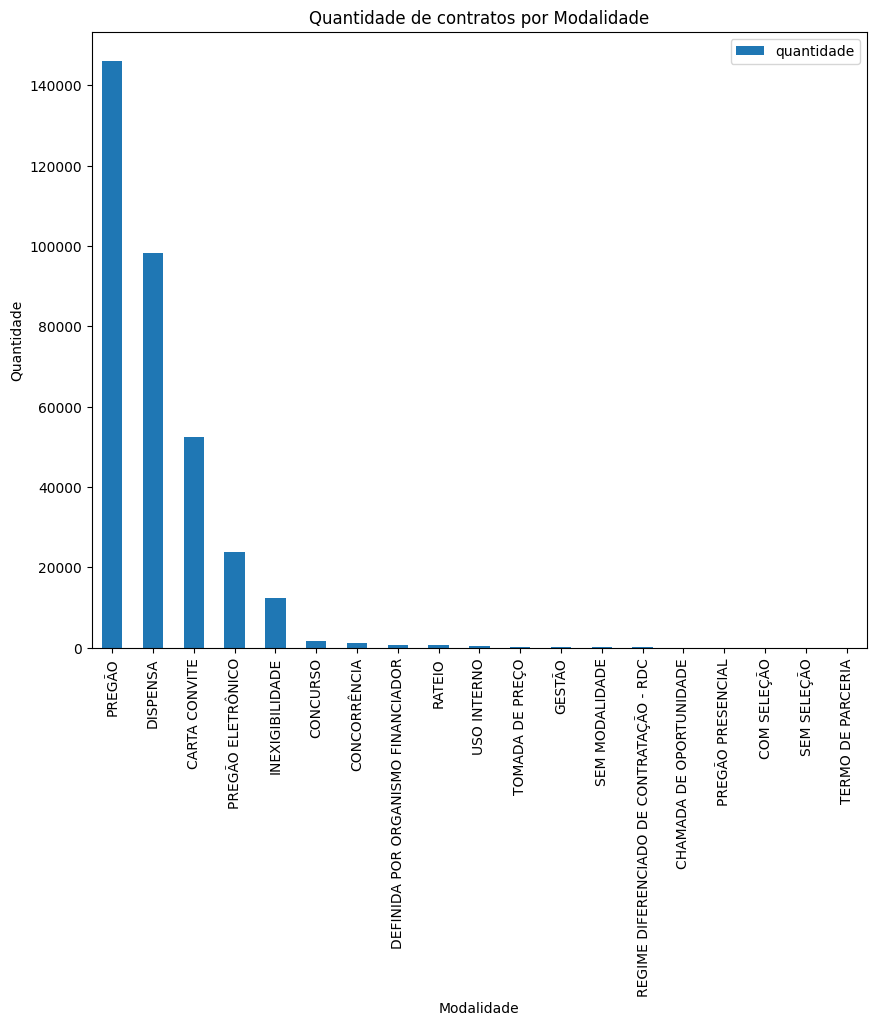

In [20]:
df_qtd_modalidade.plot(
    kind = "bar",
    x = "descricao_modalidade",
    y = ["quantidade"],
    figsize = (10,8),
    title = "Quantidade de contratos por Modalidade",
    xlabel= "Modalidade",
    ylabel= "Quantidade"
    
)

### Valor acumulado por modalidade

In [21]:
df_acumulado_modalidade = df.groupby("descricao_modalidade", observed=True)["calculated_valor_pago"]\
    .agg(["mean", "sum"]).reset_index()\
    .sort_values(by="sum", ascending=False)

# Tabela
df_acumulado_modalidade.style.format({"mean": 'R$ {:.2f}', "sum": 'R$ {:.2f}'}, na_rep='MISS', precision=2) 

,descricao_modalidade,mean,sum
9,PREGÃO,R$ 190214.86,R$ 27766042858.85
7,GESTÃO,R$ 51581970.07,R$ 15010353289.82
6,DISPENSA,R$ 115525.04,R$ 11348833470.31
3,CONCORRÊNCIA,R$ 8507964.41,R$ 10184033393.01
8,INEXIGIBILIDADE,R$ 329777.41,R$ 4122877174.21
5,DEFINIDA POR ORGANISMO FINANCIADOR,R$ 4003083.30,R$ 3166438886.96
12,RATEIO,R$ 2622388.05,R$ 1940567153.46
13,REGIME DIFERENCIADO DE CONTRATAÇÃO - RDC,R$ 6162769.42,R$ 1503715737.52
10,PREGÃO ELETRÔNICO,R$ 54491.18,R$ 1296835584.38
0,CARTA CONVITE,R$ 18171.92,R$ 952117489.64


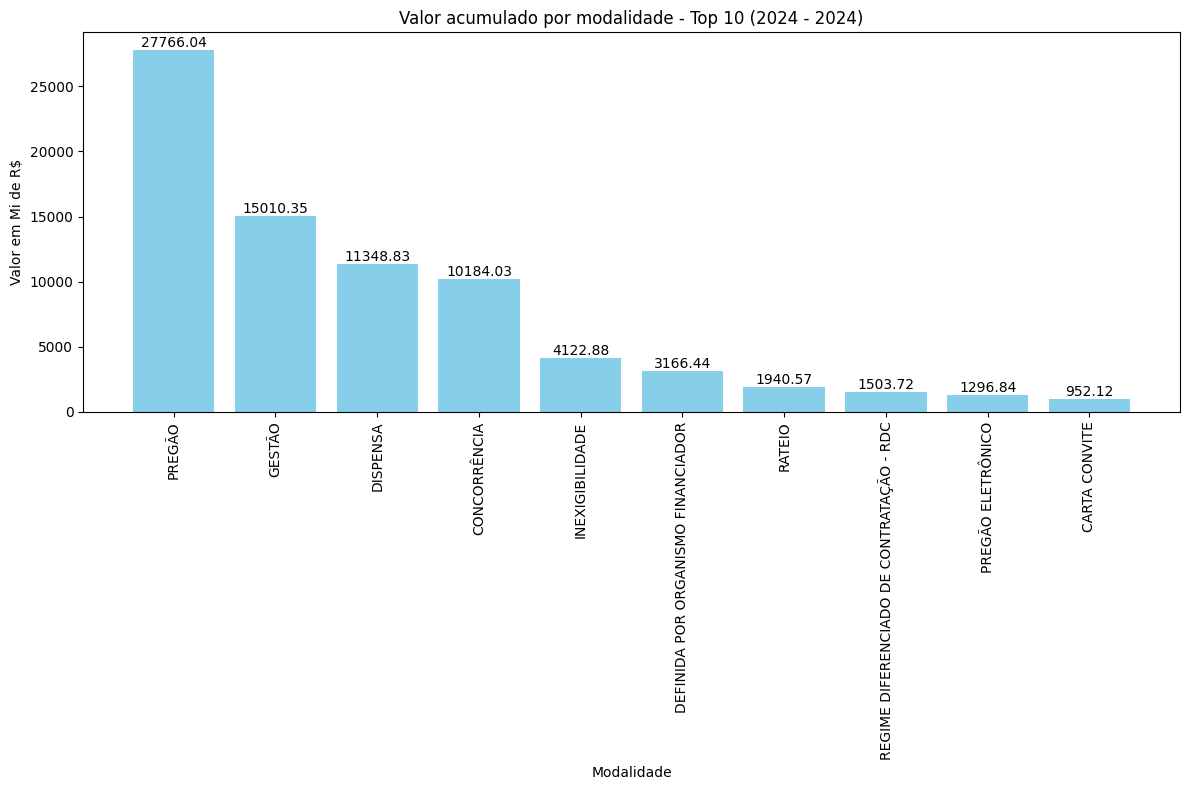

In [23]:
# Gráfico top 10
top10_modalidade_despesa = df_acumulado_modalidade
top10_modalidade_despesa["sum_mi"] = round(top10_modalidade_despesa["sum"] / 10**6, 2)
top10_modalidade_despesa = top10_modalidade_despesa.sort_values(by="sum_mi", ascending=False).head(10)

plt.figure(figsize=(12,8))
bars = plt.bar(
    top10_modalidade_despesa["descricao_modalidade"],
    top10_modalidade_despesa["sum_mi"],
    color="skyblue"
)


for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval,
        yval,
        ha = "center",
        va = "bottom"
    )
plt.title(f"Valor acumulado por modalidade - Top 10 ({primeiro_ano} - {ultimo_ano})")
plt.xlabel("Modalidade")
plt.ylabel("Valor em Mi de R$")

plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

### Quantidade de contratos por Situação do contrato

In [27]:
df_count_situacao = df.groupby("descricao_situacao", observed=True)["id"].count()\
    .reset_index(name="quantidade")\
    .sort_values(by="quantidade", ascending=False)
df_count_situacao

,descricao_situacao,quantidade
7,VENCIDO,280428
4,EM EXECUÇÃO - NORMAL,51564
2,CONCLUÍDO COM DÍVIDA,4264
1,CONCLUÍDO,1223
0,AGUARDANDO PUBLICAÇÃO DO ADITIVO,799
5,RESCINDIDO,650
6,RESCINDIDO COM DÍVIDA,116
3,EM EXECUÇÃO - BLOQUEADO SOLICITAÇÃO DE PARCELA,2


<Axes: title={'center': 'Quantidade de contratos por Modalidade'}, xlabel='Modalidade', ylabel='Quantidade'>

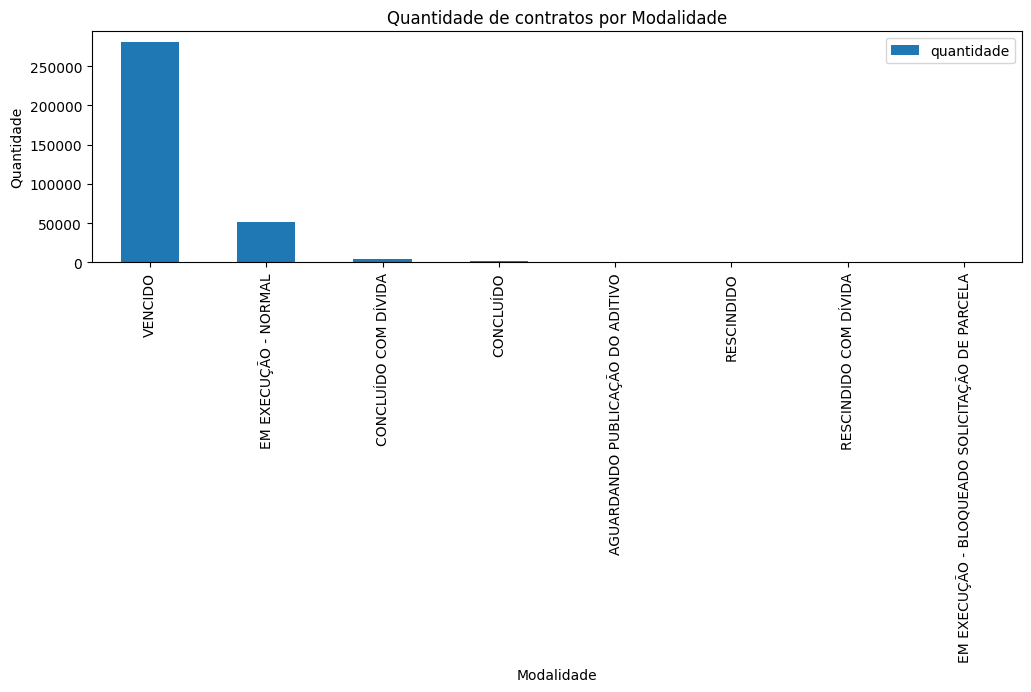

In [29]:
df_count_situacao.plot(
    kind = "bar",
    x = "descricao_situacao",
    y = ["quantidade"],
    figsize = (12,3),
    title = "Quantidade de contratos por Modalidade",
    xlabel= "Modalidade",
    ylabel= "Quantidade"
)

### Quantidade de contratos por Situação do contrato = <situação>

In [30]:
situacao = "CONCLUÍDO COM DÍVIDA"

df_temp = df
df_temp["year"] = df_temp['data_assinatura'].dt.year

df_count_situacao_situacao = df_temp[df_temp["descricao_situacao"] == situacao].groupby(["year"], observed=True)["id"].count()\
    .reset_index(name="quantidade")\
    .sort_values(by=["year"], ascending=False)
df_count_situacao_situacao

,year,quantidade
8,2022,2
7,2021,132
6,2020,225
5,2019,278
4,2018,588
3,2017,573
2,2016,719
1,2015,601
0,2014,1146


<Axes: title={'center': 'Quantidade de contratos em situação = CONCLUÍDO COM DÍVIDA'}, xlabel='Ano', ylabel='Quantidade'>

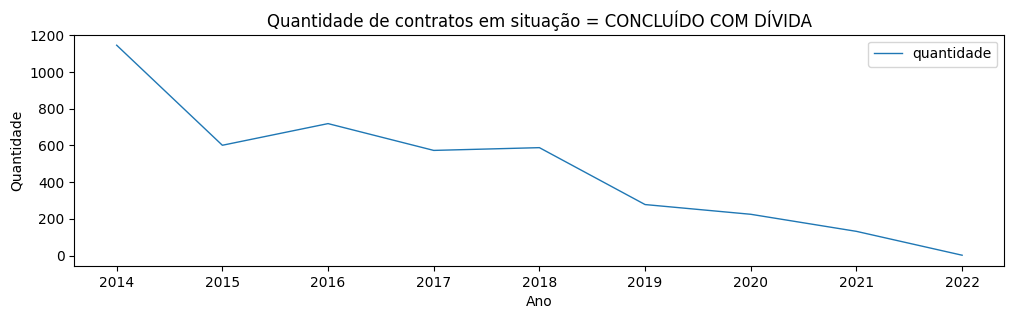

In [43]:
reduce = df_count_situacao_situacao.plot(
    kind = "line",
    x = "year",
    y = ["quantidade"],
    figsize = (12,3),
    title = f"Quantidade de contratos em situação = {situacao}",
    xlabel= "Ano",
    ylabel= "Quantidade",
    linewidth=1, 
    markersize=12
)

reduce


### Valor acumulado por Objeto do contrato

In [46]:
df_acumulado_objeto = df.groupby("tipo_objeto", observed=True)["calculated_valor_pago"]\
    .agg(["mean", "sum"])\
    .reset_index()\
    .sort_values(by="sum", ascending=False)
df_acumulado_objeto.style.format({"mean": 'R$ {:.2f}', "sum": 'R$ {:.2f}'}, na_rep='MISS', precision=2)

,tipo_objeto,mean,sum
16,Outros,R$ 188455.82,R$ 47247003922.53
15,Obras e Serviços de Engenharia,R$ 3295284.68,R$ 13141595297.89
12,Locação/Terceirização de Mão-de-obra,R$ 6262526.42,R$ 9393789629.93
2,"Aquisição de Móveis, Máquinas e Equipamentos (Matl Permanente)",R$ 179013.87,R$ 1247905706.40
7,Gêneros Alimentícios,R$ 28351.17,R$ 1107878706.45
0,Aquisição de Equipamentos e Material de Informática,R$ 396067.73,R$ 1006012030.21
6,Energia Elétrica,R$ 2148387.98,R$ 930251993.77
4,Combustíveis e Lubrificantes,R$ 2863730.37,R$ 910666256.44
18,"Peças, Acessórios e Manutenção de Veículos",R$ 408547.59,R$ 710464256.69
19,Serviços de Consultoria,R$ 1160447.12,R$ 523361650.33


/tmp/ipykernel_23993/3487586295.py:27: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


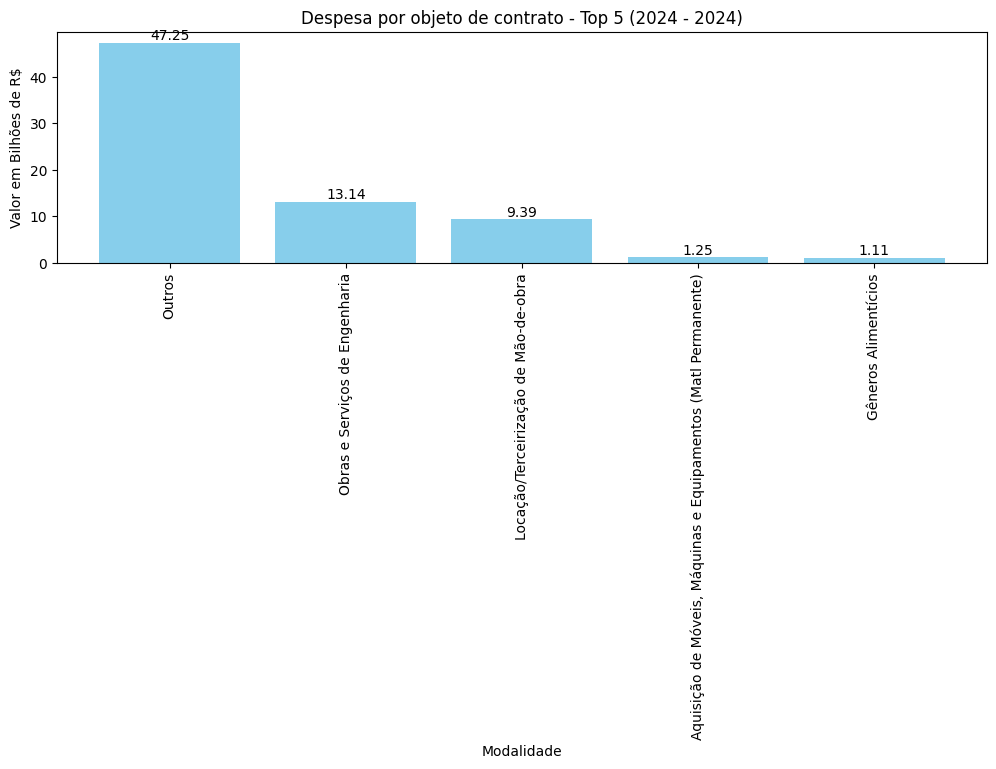

In [48]:
# Gráfico
df_acumulado_objeto["sum_bilhao"] = round(df_acumulado_objeto["sum"] / 10**9, 2)
df_acumulado_objeto = df_acumulado_objeto.sort_values(by="sum_bilhao", ascending=False).head(5)


plt.figure(figsize=(12,3))
bars = plt.bar(
    df_acumulado_objeto["tipo_objeto"],
    df_acumulado_objeto["sum_bilhao"],
    color="skyblue"
)

for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval,
        yval,
        ha = "center",
        va = "bottom"
    )
plt.title(f"Despesa por objeto de contrato - Top 5 ({primeiro_ano} - {ultimo_ano})")
plt.xlabel("Modalidade")
plt.ylabel("Valor em Bilhões de R$")

plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

### Valor acumulado por Modalidade de edital

In [49]:
df_acumulado_edital = df.groupby("descriaco_edital", observed=True)["calculated_valor_pago"]\
    .agg(["mean", "sum"])\
    .reset_index()\
    .sort_values(by="sum", ascending=False)
df_acumulado_edital.style.format({"mean": 'R$ {:.2f}', "sum": 'R$ {:.2f}'}, na_rep='MISS', precision=2)

,descriaco_edital,mean,sum
0,01. PROCESSO LICITATÓRIO,R$ 334280.52,R$ 60639488661.40
1,19. REGISTRO DE PREÇO,R$ 72116.20,R$ 10977743668.96
2,22.TERMO DE ADESÃO A REGISTRO DE PREÇO EXTERNO (CARONA),R$ 719488.81,R$ 2754922661.65
5,34. CONTRATOS DE RATEIO,R$ 2622388.05,R$ 1940567153.46
3,26.CONTRATO PARA SUBVENÇÃO ECONÔMICA/TERMO DE COMPROMISSO,R$ 1713121.33,R$ 911380549.88
4,33. CONTRATOS DE GESTÃO,R$ 31317929.44,R$ 407133082.77
6,42. CONTRATO DE PATROCÍNIO,R$ 212155.83,R$ 53463268.08


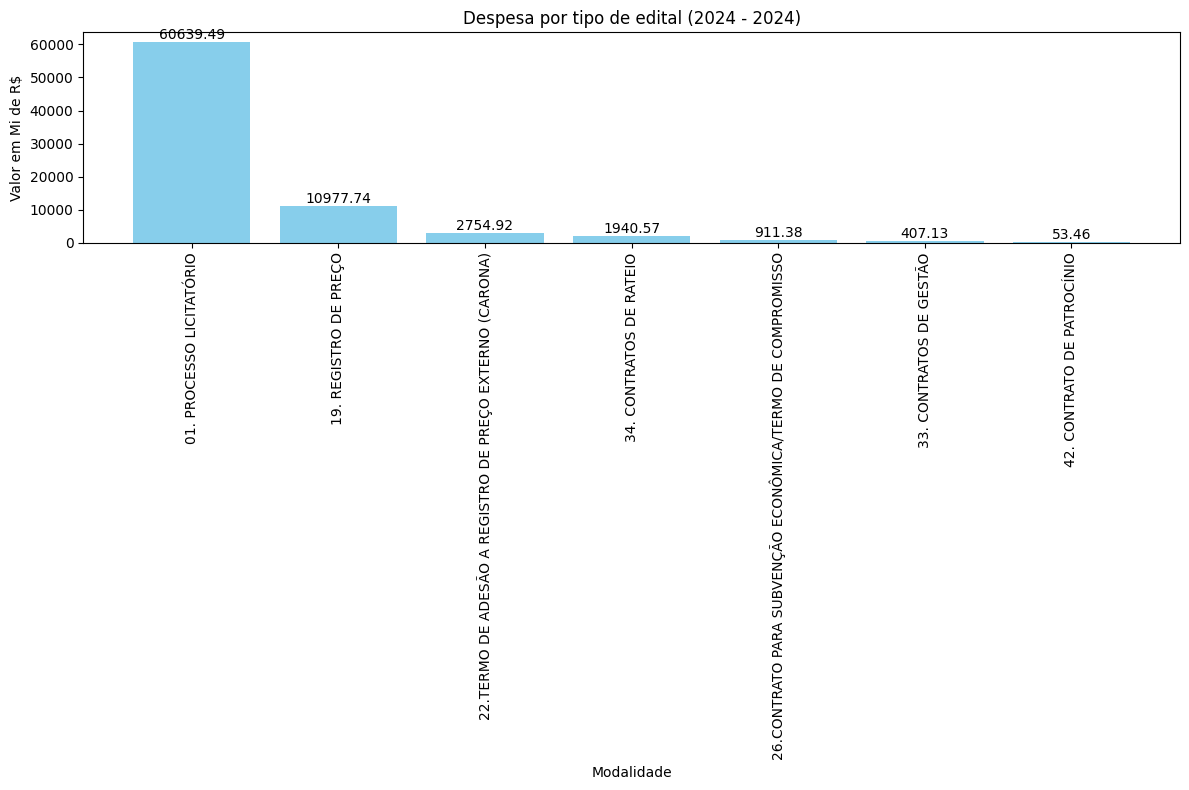

In [50]:
# Gráfico
df_acumulado_edital["sum_mi"] = round(df_acumulado_edital["sum"] / 10**6, 2)
df_acumulado_edital = df_acumulado_edital.sort_values(by="sum_mi", ascending=False)


plt.figure(figsize=(12,8))
bars = plt.bar(
    df_acumulado_edital["descriaco_edital"],
    df_acumulado_edital["sum_mi"],
    color="skyblue"
)

for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval,
        yval,
        ha = "center",
        va = "bottom"
    )
plt.title(f"Despesa por tipo de edital ({primeiro_ano} - {ultimo_ano})")
plt.xlabel("Modalidade")
plt.ylabel("Valor em Mi de R$")

plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

### Somatório do valor por Tipo de contrato

In [51]:
df_acumulado_tipo = df.groupby("descricao_tipo", observed=True)["calculated_valor_pago"]\
    .agg(["mean", "sum"])\
    .reset_index()\
    .sort_values(by="sum", ascending=False)
df_acumulado_tipo.style.format({"mean": 'R$ {:.2f}', "sum": 'R$ {:.2f}'}, na_rep='MISS', precision=2)

,descricao_tipo,mean,sum
0,CONTRATO,R$ 686221.00,R$ 72920588773.75
2,DESPESA.SEM.INSTRUMENTO.CONTRATUAL,R$ 21028.82,R$ 4883712807.67
1,CONTRATO.SUBVENCAO,R$ 1713121.33,R$ 911380549.88


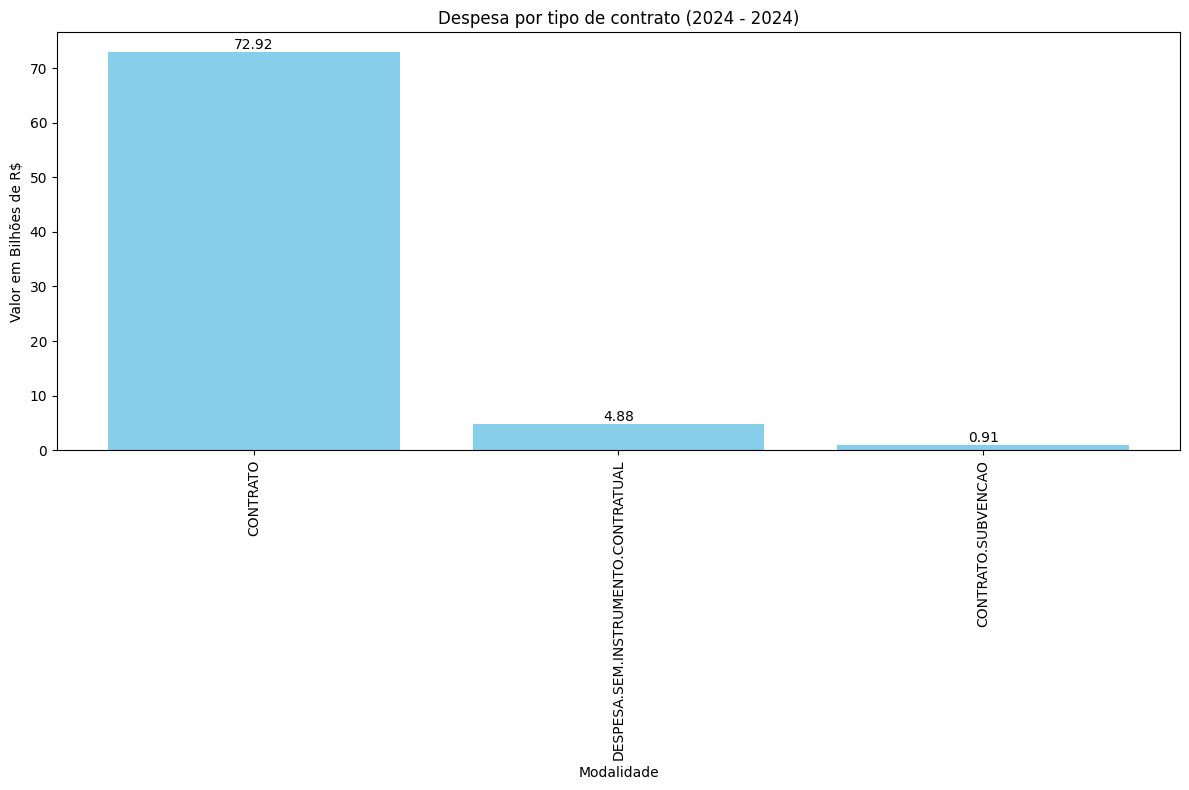

In [52]:
# Gráfico
df_acumulado_tipo["sum_bi"] = round(df_acumulado_tipo["sum"] / 10**9, 2)
df_acumulado_tipo = df_acumulado_tipo.sort_values(by="sum_bi", ascending=False).head(5)


plt.figure(figsize=(12,8))
bars = plt.bar(
    df_acumulado_tipo["descricao_tipo"],
    df_acumulado_tipo["sum_bi"],
    color="skyblue"
)

for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval,
        yval,
        ha = "center",
        va = "bottom"
    )
plt.title(f"Despesa por tipo de contrato ({primeiro_ano} - {ultimo_ano})")
plt.xlabel("Modalidade")
plt.ylabel("Valor em Bilhões de R$")

plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

### Quantidade de contratos assinados por ano

In [73]:
temp_df = df
temp_df["year"] = temp_df['data_assinatura'].dt.year
df_assinatura_por_ano = temp_df.groupby("year", observed=True)["id"].count()\
    .reset_index(name="quantidade")\
    .sort_values(by="year", ascending=True)
df_assinatura_por_ano

,year,quantidade
0,2014,26469
1,2015,22665
2,2016,20497
3,2017,26393
4,2018,28568
5,2019,40611
6,2020,34681
7,2021,36858
8,2022,46485
9,2023,46084


<Axes: title={'center': 'Assinatura de contratos por ano'}, xlabel='Ano', ylabel='Quantidade'>

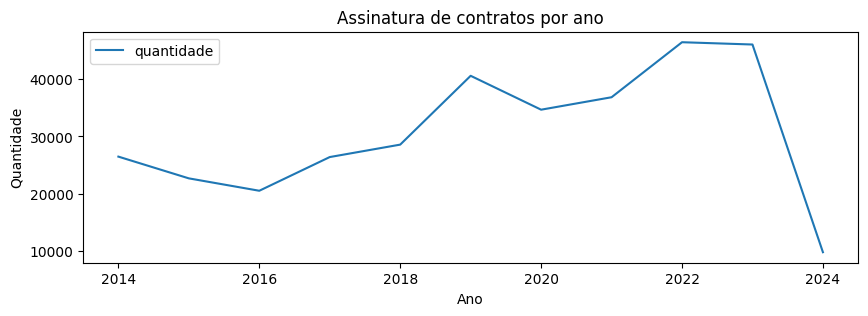

In [55]:
df_assinatura_por_ano.plot(
    kind = "line",
    x = "year",
    y = ["quantidade"],
    figsize = (10,3),
    title = "Assinatura de contratos por ano",
    xlabel= "Ano",
    ylabel= "Quantidade"
    
)

### Somatório do valor de contratos assinados em <ano> por mês

In [ ]:
ano = 2024


temp_df = df
temp_df["year"] = temp_df['data_assinatura'].dt.year
temp_df["month"] = temp_df['data_assinatura'].dt.month

df_assinatura_ano_mes = df[df["year"] == ano].groupby(["month"], observed=True)["calculated_valor_pago"]\
    .agg(["mean", "sum"]).div(10**6)\
    .reset_index()\
    .sort_values(by=["month"], ascending=True)
df_assinatura_ano_mes.style.format({"mean": 'R$ {:.2f} Mi', "sum": 'R$ {:.2f} Mi'}, na_rep='MISS', precision=2)

In [ ]:
# plot usando pandas
df_assinatura_ano_mes.plot(
    kind = "line",
    x = "month",
    y = ["sum", "mean"],
    figsize = (10,8),
    title = f"Despesas por mês ({ano})",
    xlabel= "Mês",
    ylabel= "Valor em Milhões de R$"  
)

# Persiste os dados em .parket e .csv

In [ ]:
# Mantém os tipos dos dados e mais compacto
df.to_parquet("dataset.parquet")

In [ ]:
# Amplamente utilizado
df.to_csv("dataset.csv", encoding="utf-8", index=False)

# Insights
Com base na análise exploratória realizada, identifique e apresente pelo menos três insights relevantes obtidos dos dados. Explique cada insight e como ele pode ser útil em um contexto prático.

### 1. Apesar do crescente número de contratos assinados ao longo do ano, a quantidade de contratos em situação de "concluído com dívida" teve um decrescimo.

<Axes: title={'center': 'Assinatura de contratos por ano / situação com dívida'}, xlabel='Ano', ylabel='Quantidade'>

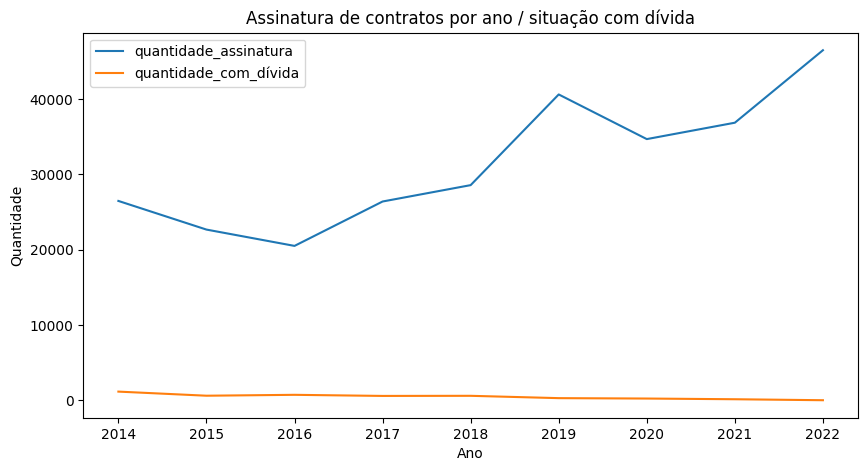

In [88]:
df_insignt_01 = df_assinatura_por_ano.merge(df_count_situacao_situacao, on='year', suffixes=("_assinatura", "_com_dívida"))
df_insignt_01.plot(
    kind = "line",
    x = "year",
    y = ["quantidade_assinatura", "quantidade_com_dívida"],
    figsize = (10,5),
    title = "Assinatura de contratos por ano / situação com dívida",
    xlabel= "Ano",
    ylabel= "Quantidade"
    
)

<Axes: title={'center': 'Assinatura de contratos por ano'}, xlabel='Ano', ylabel='Quantidade'>

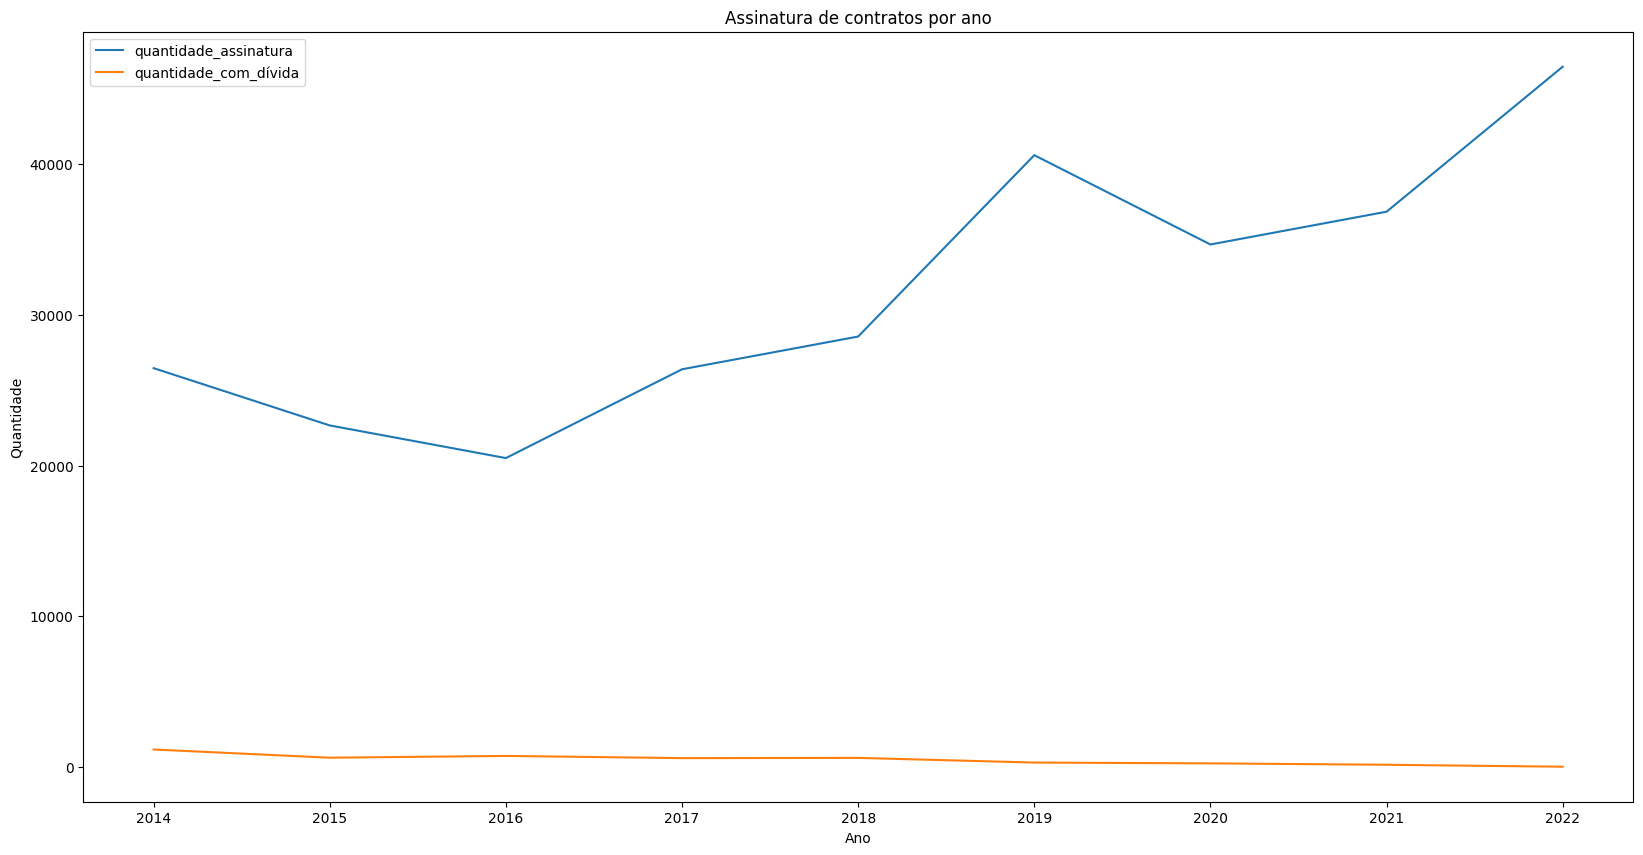

### 2. 

### 3. 

# Reflexão sobre a importância e aplicabilidade desses insights

# Comparativo entre formatos de arquivo

In [ ]:
%%time
par_df = pd.read_parquet("dataset.parquet")
par_df.shape

In [ ]:
%%time
csv_df = pd.read_csv("dataset.csv", low_memory=False)
csv_df.shape